#### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Load dataset

In [3]:
df = pd.read_csv("D:\Projects\Sales_EDA_Dashboard\Data\Processed\Sales_Data_Clean.csv")
df.head()

,Unnamed: 0,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour,Year,Day,Weekday
0,0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.00,New York City,0,2019,30,Monday
1,1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.00,New York City,7,2019,29,Sunday
2,2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",12,11.95,New York City,18,2019,12,Thursday
3,3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",12,149.99,San Francisco,15,2019,22,Sunday
4,4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",12,11.95,Atlanta,12,2019,18,Wednesday


#### Overview of Dataset: columns, dtypes, non-null counts

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        185950 non-null  int64  
 1   Order ID          185950 non-null  int64  
 2   Product           185950 non-null  object 
 3   Quantity Ordered  185950 non-null  int64  
 4   Price Each        185950 non-null  float64
 5   Order Date        185950 non-null  object 
 6   Purchase Address  185950 non-null  object 
 7   Month             185950 non-null  int64  
 8   Sales             185950 non-null  float64
 9   City              185950 non-null  object 
 10  Hour              185950 non-null  int64  
 11  Year              185950 non-null  int64  
 12  Day               185950 non-null  int64  
 13  Weekday           185950 non-null  object 
dtypes: float64(2), int64(7), object(5)
memory usage: 19.9+ MB


#### Summary stats for numerical columns 

In [5]:
df.describe()

,Unnamed: 0,Order ID,Quantity Ordered,Price Each,Month,Sales,Hour,Year,Day
count,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000,185950.000000
mean,8340.388475,230417.569379,1.124383,184.399735,7.059140,185.490917,14.413305,2019.000183,15.759532
std,5450.554093,51512.737110,0.442793,332.731330,3.502996,332.919771,5.423416,0.013521,8.782176
min,0.000000,141234.000000,1.000000,2.990000,1.000000,2.990000,0.000000,2019.000000,1.000000
25%,3894.000000,185831.250000,1.000000,11.950000,4.000000,11.950000,11.000000,2019.000000,8.000000
50%,7786.000000,230367.500000,1.000000,14.950000,7.000000,14.950000,15.000000,2019.000000,16.000000
75%,11872.000000,275035.750000,1.000000,150.000000,10.000000,150.000000,19.000000,2019.000000,23.000000
max,25116.000000,319670.000000,9.000000,1700.000000,12.000000,3400.000000,23.000000,2020.000000,31.000000


#### Convert the type for the Order Date column to datetime

In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create a new dataframe
daily_sales = df.groupby(df['Order Date'].dt.date)['Sales'].sum().reset_index()

# Rename the column
daily_sales.rename(columns={'Order Date': 'date', 'Sales': 'sales'}, inplace=True)

# Set index as the date to make time series
daily_sales['date'] = pd.to_datetime(daily_sales['date'])
daily_sales = daily_sales.set_index('date')

daily_sales.head()

,sales
date,
2019-01-01,65681.94
2019-01-02,70813.20
2019-01-03,47046.20
2019-01-04,62012.21
2019-01-05,46524.63


#### Show shape of dataset (rows, columns)

In [7]:
daily_sales.shape

(366, 1)

#### Plotting Time Series to observe trends, seasonality, outliers

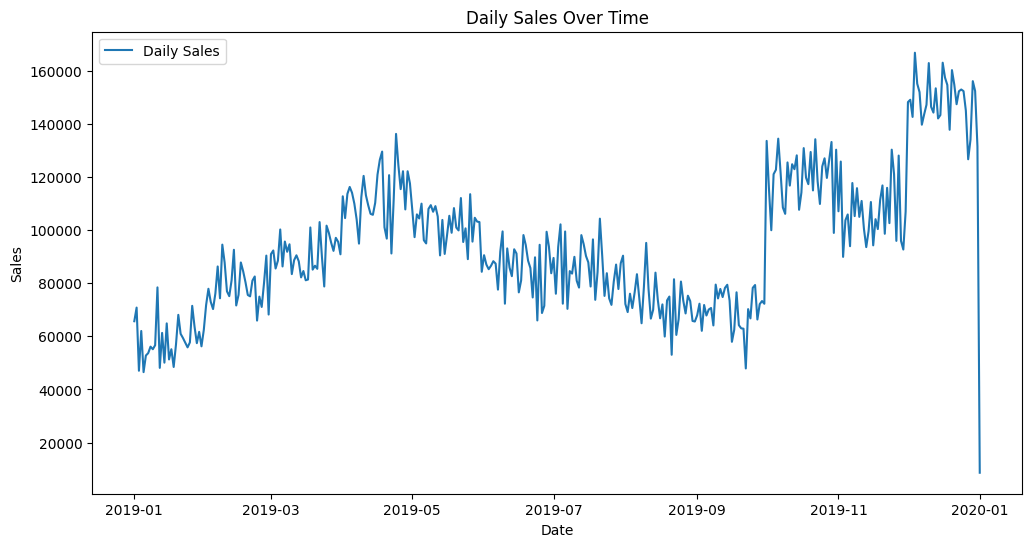

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales["sales"], label="Daily Sales")
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

#### Run auto_arima to automatically find the best ARIMA/SARIMA model for daily sales data

In [9]:
stepwise_model = auto_arima(
    daily_sales['sales'], 
    start_p=1, start_q=1,
    max_p=5, max_q=5, m=7,  # m=7 nếu có seasonality theo tuần
    start_P=0, seasonal=True, 
    d=None, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=7876.648, Time=1.42 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8031.873, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7955.641, Time=0.33 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=7972.369, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8031.853, Time=0.06 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=7988.946, Time=0.30 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=7897.113, Time=0.69 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=7897.053, Time=0.73 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=7932.757, Time=0.41 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=7879.215, Time=3.99 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=7926.813, Time=0.33 sec
 ARIMA(2,0,1)(0,1,1)[7] intercept   : AIC=7877.329, Time=1.86 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=7891.899, Time=0.56 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=8018.000, Time=0.18 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept

The log result shows that auto_arima has tried many combinations (p,d,q)(P,D,Q)[m]
→ This is how to find the best set of parameters for the SARIMA model.

In log, the model with the smallest AIC is ARIMA(2,0,2)(0,1,1)[7], with AIC ≈ 7876.304
That means the Seasonal ARIMA model has:

- p=2, d=0, q=2 (non-seasonal ARIMA)

- P=0, D=1, Q=1 (seasonal ARIMA)

- m=7 (weekly seasonality cycle)

=> This is the optimal model chosen by auto_arima to forecast daily sales.

The meaning of AIC in choosing ARIMA model
- **AIC (Akaike Information Criterion)** is used to compare models.
- Formula: `AIC = 2k - 2ln(L)`
- `k`: number of model parameters
- `L`: suitability (likelihood)
- AIC balances between:
- Data fit (high likelihood)
- Complexity (fewer parameters is better)
- **The model with the smallest AIC → is selected as the optimal model**.
- In the above results, **ARIMA(2,0,2)(0,1,1)[7]** has AIC ≈ 7876.3 → is the best model.

#### Train/Test split over time

In [10]:
# Assuming daily_sales is a prepared series: index=DatetimeIndex (date), column 'sales'
y = daily_sales['sales'].astype(float)

# 80% train – 20% test
split_idx = int(len(y)*0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#### Fit model on train

In [11]:
model = auto_arima(
    y_train, order=(2,0,2), seasonal=True, m=7,
    D=1, start_P=0, trace=False, error_action='ignore', suppress_warnings=True
)

#### Prediction on Test set and evaluation

In [12]:
# Fore with test lenght
pred = model.predict(n_periods=len(y_test))
pred = pd.Series(pred, index=y_test.index)

# Metrics 
mae  = mean_absolute_error(y_test, pred)
rmse = sqrt(mean_squared_error(y_test, pred))
mape = (np.abs((y_test - pred) / y_test)
        .replace([np.inf, -np.inf], np.nan).dropna()).mean()*100

print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:,.2f}%")

MAE : 19,737.76
RMSE: 25,155.56
MAPE: 33.11%


#### Plot Actual vs Forecast (Test)

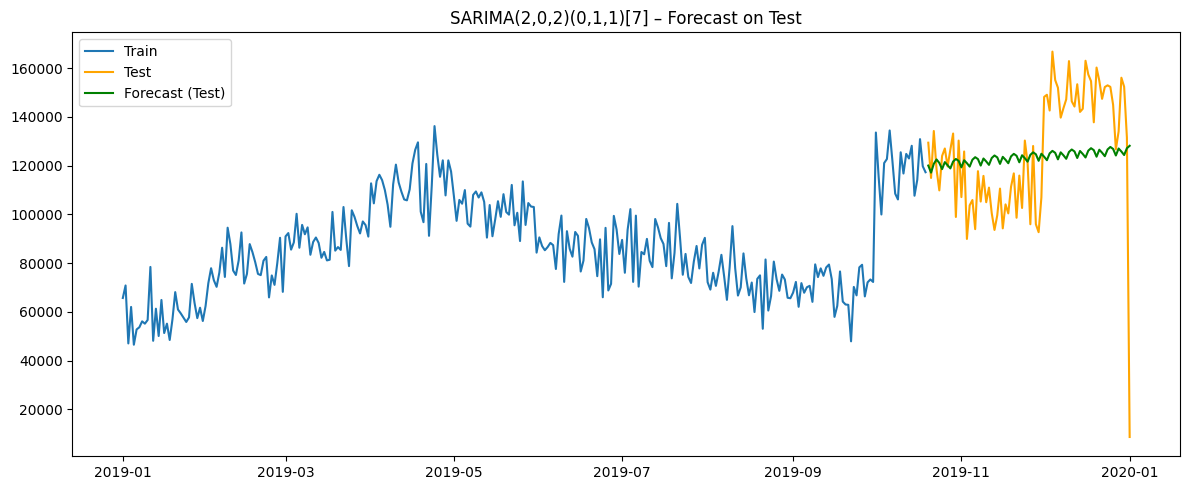

In [13]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index,  y_test,  label="Test", color='orange')
plt.plot(pred.index,    pred,    label="Forecast (Test)", color='green')
plt.title("SARIMA(2,0,2)(0,1,1)[7] – Forecast on Test")
plt.legend(); plt.tight_layout(); plt.show()

#### Check residual (forecast error)

Residual mean: 2104.14


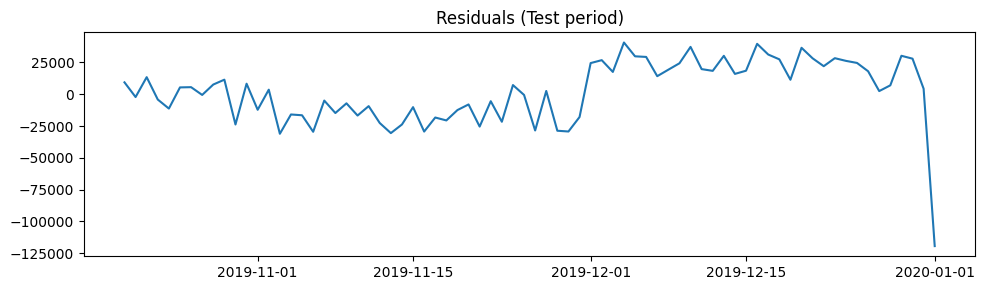

In [14]:
resid = y_test - pred
print("Residual mean:", resid.mean().round(2))

plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values)
plt.title("Residuals (Test period)")
plt.tight_layout(); plt.show()

#### Refit all data & Forecast future

In [15]:
# Retrain on the entire dataset
final_model = auto_arima(
    y, order=(2,0,2), seasonal=True, m=7,
    D=1, start_P=0, trace=False, 
    error_action='ignore', suppress_warnings=True
)

# Forecast for the next 30 days
h = 30
fcst = final_model.predict(n_periods=h)
future_idx = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=h, freq='D')
forecast_df = pd.DataFrame({"date": future_idx, "forecast_arima": fcst})
forecast_df.set_index("date", inplace=True)

#### Draw Future Forecas

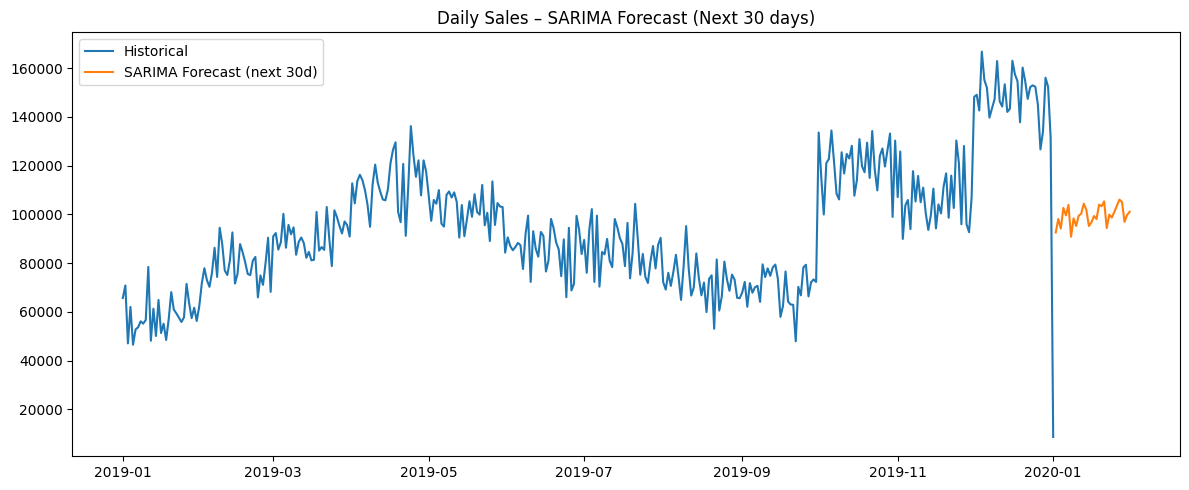

In [16]:
plt.figure(figsize=(12,5))
plt.plot(y.index, y.values, label="Historical")
plt.plot(forecast_df.index, forecast_df['forecast_arima'], 
         label="SARIMA Forecast (next 30d)", linestyle='-')
plt.title("Daily Sales – SARIMA Forecast (Next 30 days)")
plt.legend()
plt.tight_layout()
plt.show()

ARIMA cannot model seasonality, so the error is still high. Therefore, we switch to SARIMA with m=30 to handle weekly seasonality.

#### Fit SARIMA model with m=30 (monthly seasonality)

In [17]:
sarima_model_m30 = sm.tsa.statespace.SARIMAX(
    y_train, 
    order=(2,0,2),              
    seasonal_order=(0,1,1,30),  
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Prediction on Test set and evaluation

In [18]:
forecast_m30 = sarima_model_m30.predict(start=len(y_train), 
                                        end=len(y_train)+len(y_test)-1, 
                                        dynamic=False)

In [19]:
mae = mean_absolute_error(y_test, forecast_m30)
rmse = np.sqrt(mean_squared_error(y_test, forecast_m30))
mape = np.mean(np.abs((y_test - forecast_m30) / y_test)) * 100

print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

MAE : 21369.28
RMSE: 26642.87
MAPE: 32.23 %


#### Plot Actual vs Forecast (Test)

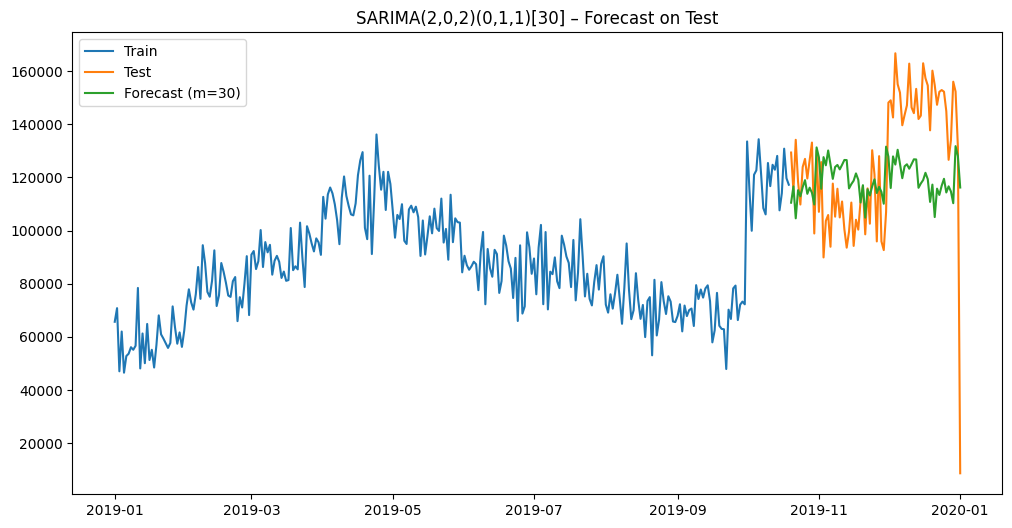

In [20]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(forecast_m30, label="Forecast (m=30)")
plt.title("SARIMA(2,0,2)(0,1,1)[30] – Forecast on Test")
plt.legend()
plt.show()

#### Check residual (forecast error)

Residual mean: 2104.14


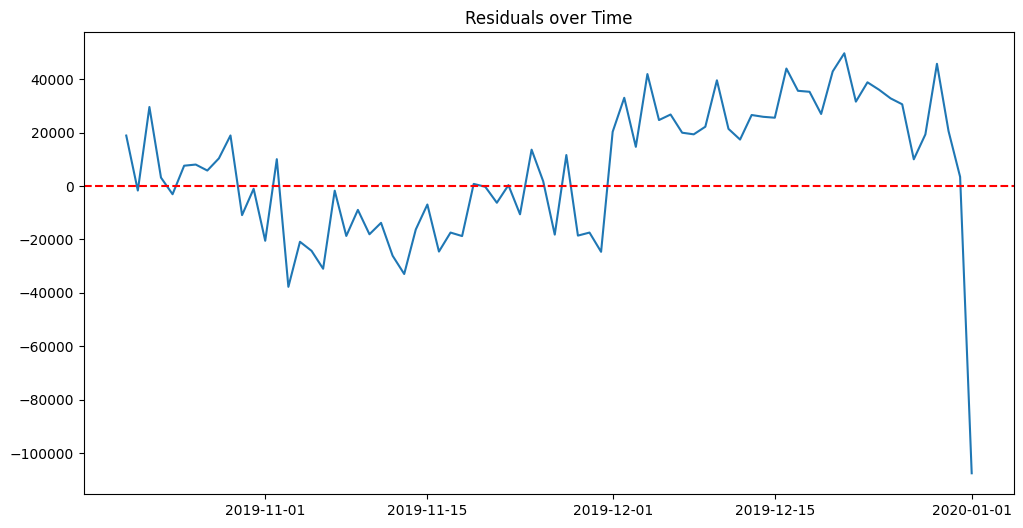

In [21]:
# Residuals (difference between actual and forecast)
residuals = y_test - forecast_m30
print("Residual mean:", resid.mean().round(2))

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.axhline(0, linestyle="--", color="red")
plt.title("Residuals over Time")
plt.show()

#### Refit all data & Forecast future

In [22]:
# Retrain on the entire dataset
sarima_full = sm.tsa.statespace.SARIMAX(
    daily_sales['sales'],    
    order=(2,0,2),           
    seasonal_order=(0,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the next 30 days
n_steps = 30  # số ngày tương lai muốn dự báo
forecast_future = sarima_full.get_forecast(steps=n_steps)
forecast_mean = forecast_future.predicted_mean
forecast_ci = forecast_future.conf_int()  # khoảng tin cậy 95% 

#### Draw Future Forecast

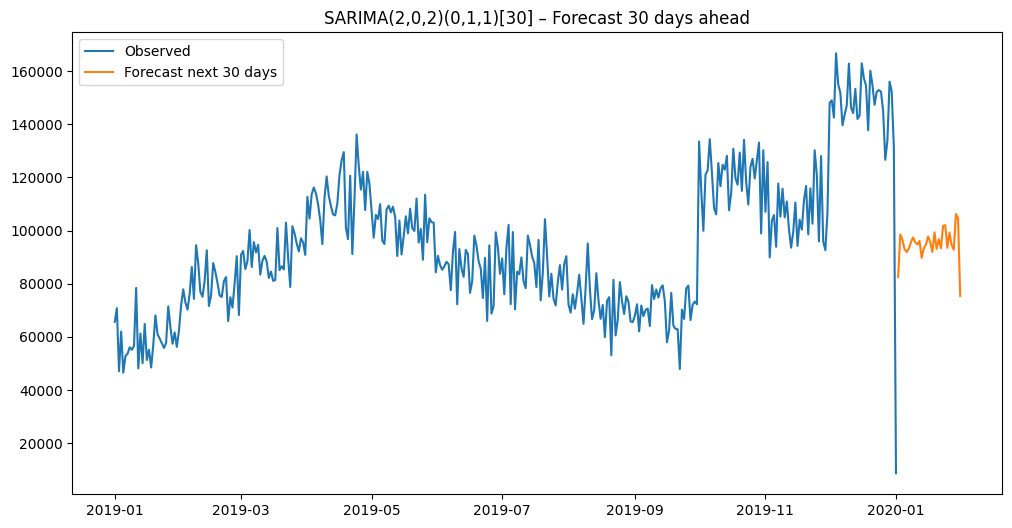

In [23]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales['sales'], label="Observed")
plt.plot(forecast_mean, label=f"Forecast next {n_steps} days")
plt.title(f"SARIMA(2,0,2)(0,1,1)[30] – Forecast {n_steps} days ahead")
plt.legend()
plt.show()

In the observed data, there are some days with unusual spikes. These points do not reflect normal business rules but are more likely due to outliers (holidays, system errors, incorrect data entry). If kept as is, just a few outliers will significantly increase the RMSE/MAE error, obscuring the overall trend forecast quality. Therefore, we will try to filter out the outliers in the original data set to evaluate the model more objectively.

#### Copy daily_sales dataframe

In [24]:
daily_sales_2 = daily_sales.copy()
daily_sales_2.head()

,sales
date,
2019-01-01,65681.94
2019-01-02,70813.20
2019-01-03,47046.20
2019-01-04,62012.21
2019-01-05,46524.63


#### Use IQR to find outliers

In [25]:
# --- Find outlier using IQR ---
Q1 = daily_sales_2['sales'].quantile(0.25)
Q3 = daily_sales_2['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask for "valid" data
mask = (daily_sales_2['sales'] >= lower_bound) & (daily_sales_2['sales'] <= upper_bound)

# --- View outlier ---
outliers = daily_sales_2[~mask]
print("Outliers:\n", outliers)

Outliers:
                 sales
date                 
2019-12-04  166727.69
2019-12-10  162832.74
2019-12-16  162970.61
2020-01-01    8670.29


#### Remove outlier

In [26]:
# --- Clean data ---
daily_sales_clean = daily_sales_2[mask].copy()

# Đảm bảo index là DatetimeIndex và có tần suất ngày
daily_sales_clean.index = pd.to_datetime(daily_sales_clean.index)

print("\nAfter remove outlier:")
print(daily_sales_clean.head())


After remove outlier:
               sales
date                
2019-01-01  65681.94
2019-01-02  70813.20
2019-01-03  47046.20
2019-01-04  62012.21
2019-01-05  46524.63


#### #### Train/Test split over time

In [27]:
# Assuming daily_sales is a prepared series: index=DatetimeIndex (date), column 'sales'
y = daily_sales_clean['sales'].astype(float)

# 80% train – 20% test
split_idx = int(len(y)*0.8)
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#### Fit model on train

In [28]:
sarima_model_m30 = sm.tsa.statespace.SARIMAX(
    y_train, 
    order=(2,0,2),              
    seasonal_order=(0,1,1,30),  
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

#### Prediction on Test set and evaluation

In [29]:
# Forecast with test lenght
forecast_m30 = sarima_model_m30.predict(start=len(y_train), 
                                        end=len(y_train)+len(y_test)-1, 
                                        dynamic=False)

In [30]:
# --- Metrics ---
mae = mean_absolute_error(y_test, forecast_m30)
rmse = np.sqrt(mean_squared_error(y_test, forecast_m30))
mape = np.mean(np.abs((y_test - forecast_m30) / y_test)) * 100

print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")

MAE : 20530.69
RMSE: 24418.96
MAPE: 15.51 %


#### Plot Actual vs Forecast (Test)

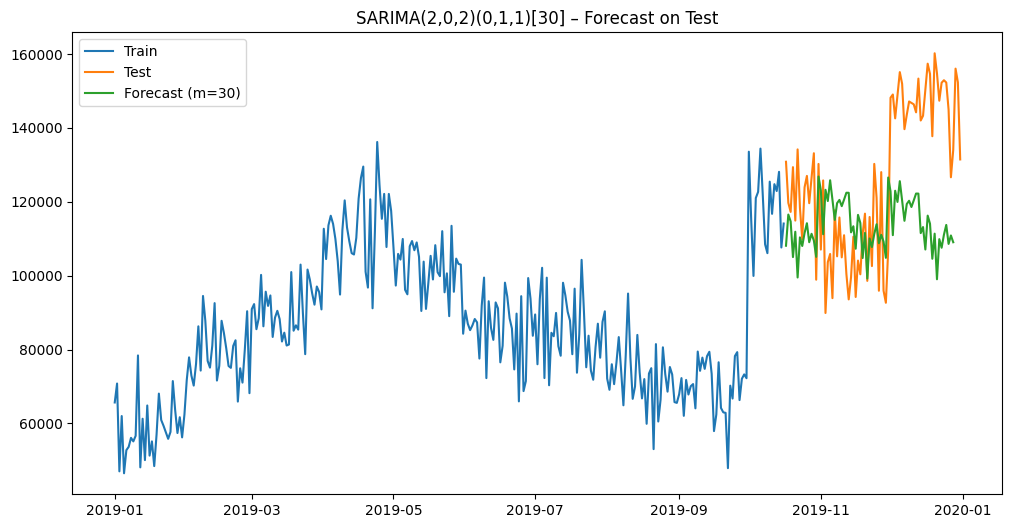

In [31]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label="Train")
plt.plot(y_test, label="Test")
plt.plot(forecast_m30, label="Forecast (m=30)")
plt.title("SARIMA(2,0,2)(0,1,1)[30] – Forecast on Test")
plt.legend()
plt.show()

#### Check residual (forecast error)

Residual mean: 10633.82


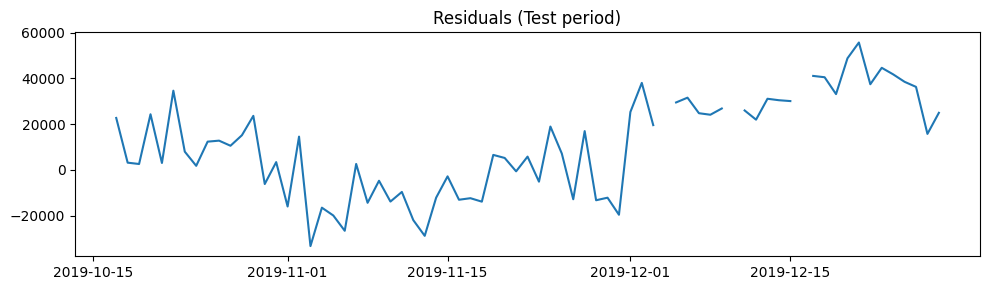

In [32]:
resid = y_test - forecast_m30
print("Residual mean:", resid.mean().round(2))

plt.figure(figsize=(10,3))
plt.plot(resid.index, resid.values)
plt.title("Residuals (Test period)")
plt.tight_layout(); plt.show()

#### Refit all data & Forecast future

In [33]:
# Retrain on the entire dataset
sarima_full = sm.tsa.statespace.SARIMAX(
    daily_sales_clean['sales'],    
    order=(2,0,2),           
    seasonal_order=(0,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


#### Draw Future Forecast

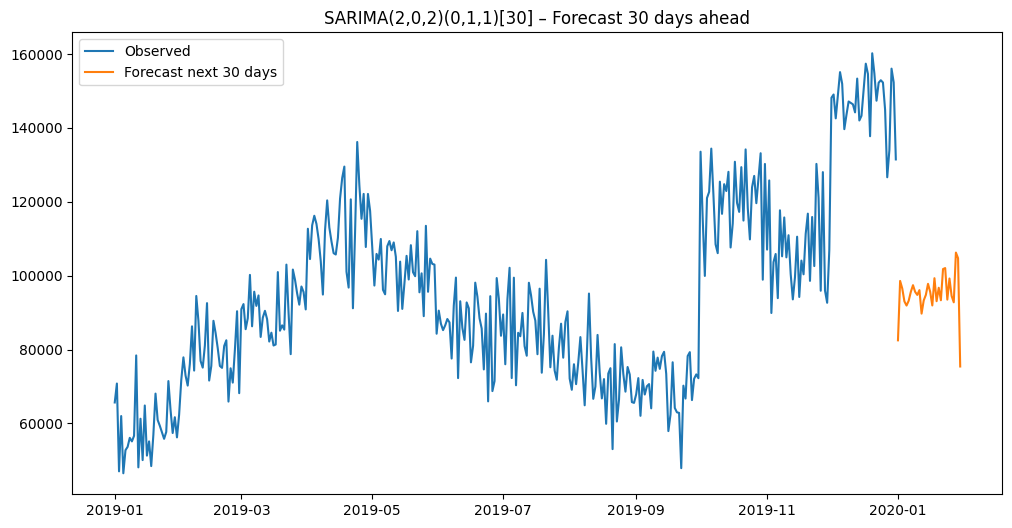

In [34]:
# Forecast for the next 30 days
n_steps = 30  # số ngày tương lai muốn dự báo
forecast_future = sarima_full.get_forecast(steps=n_steps)
forecast_index = pd.date_range(start=daily_sales_clean.index[-1] + pd.Timedelta(days=1),
                               periods=n_steps, freq="D")
forecast_mean.index = forecast_index
forecast_ci.index = forecast_index

plt.figure(figsize=(12,6))
plt.plot(daily_sales_clean['sales'], label="Observed")
plt.plot(forecast_mean, label=f"Forecast next {n_steps} days")
plt.title(f"SARIMA(2,0,2)(0,1,1)[30] – Forecast {n_steps} days ahead")
plt.legend()
plt.show()

After removing outliers, the model performs more accurately.